<a href="https://colab.research.google.com/github/bjg5091/Capstone-3-COVID-Image-Processing/blob/main/Capstone_3_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.color
import skimage.filters
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

#data = pd.read_csv('metadata.csv')

from google.colab import files
uploaded = files.upload()

print(tf.__version__)

Saving metadata.csv to metadata (2).csv
2.11.0


In [44]:
import io
data = pd.read_csv(io.BytesIO(uploaded['metadata.csv']))
# Dataset is now stored in a Pandas Dataframe

In [45]:
data.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [46]:
data.shape

(21165, 6)

In [47]:
data['label'].value_counts()

Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: label, dtype: int64

In [48]:
import cv2
import glob
from skimage.filters import gaussian
from skimage import img_as_ubyte
from google.colab import drive
drive.mount('COVID-19_Radiography_Dataset/')

Drive already mounted at COVID-19_Radiography_Dataset/; to attempt to forcibly remount, call drive.mount("COVID-19_Radiography_Dataset/", force_remount=True).


In [49]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/COVID-19_Radiography_Dataset/MyDrive/COVID-19_Radiography_Dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [50]:
cwd = os.getcwd()
print(cwd)

/content


In [51]:
import pathlib

image_list = []
path = '/tmp/COVID-19_Radiography_Dataset/'
data_dir = pathlib.Path(path).with_suffix('')
print(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

/tmp/COVID-19_Radiography_Dataset
21165


In [52]:
image_list = []
path_covid = '/tmp/COVID-19_Radiography_Dataset/COVID/*.*'

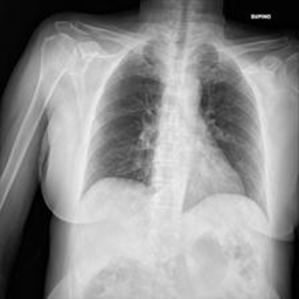

In [53]:
covid = list(data_dir.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

In [54]:
batch_size = 32
img_height = 299
img_width = 299

In [55]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.84,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 3387 files for training.


In [56]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.04,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21165 files belonging to 4 classes.
Using 846 files for validation.


In [57]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


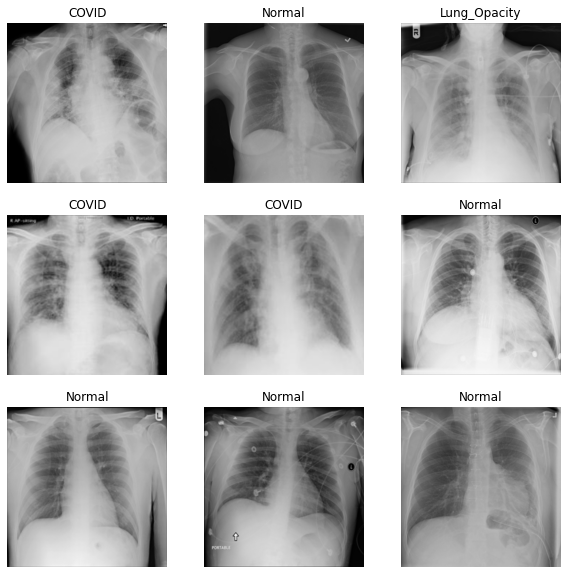

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [59]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


In [60]:
from PIL import Image
import random 
imsize = (299,299)

## Collect intensity of every pixel in every image
## Only do this once
intensities = []
for root, dirs, files in os.walk("/tmp/COVID-19_Radiography_Dataset/COVID", topdown=True):
    for name in files:
        rootname = os.path.join(root, name)
        im = Image.open(rootname)
        if im.size == imsize:
            intensities.extend(  list( im.getdata() )     )
        im.close()
            
## Save Intensities to a file because of how big it is to avoid having to rebuild it each time                                          
intensities_df = pd.DataFrame(data={"Intensity": intensities})
intensities_df.to_csv("./intensities.csv", sep=',',index=False)
        
## Too much data to reasonably plot, instead take a random sampling (0.001%).
# A large sample taken completely randomly should be representative
intensities_sample = random.sample(intensities, round(0.001 * len(intensities))  )
intensities_sample = [x for x in intensities_sample if type(x) is int] # Remove stray tuples 
## Save sample to file also
sample_df = pd.DataFrame(data={"Intensity": intensities_sample})
sample_df.to_csv("./intensities_sample.csv", sep=',',index=False)

# Remove intensities and _df to free up memory
del intensities
del intensities_df

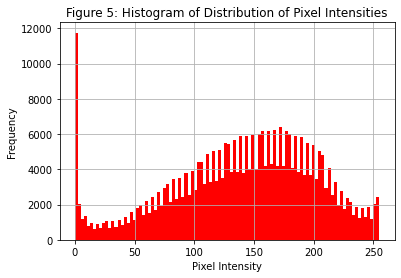

In [61]:
## Code to retrieve sample
intensities_sample = pd.read_csv('./intensities_sample.csv')
# intensities_sample = intensities_sample.sample(n= round(0.05 * len(intensities_sample)) )
intensities_sample = intensities_sample.Intensity
intensities_sample = [x for x in intensities_sample if type(x) is int] # Remove stray tuples 

## plot histogram of distribution of pixel intensities
plt.hist(intensities_sample, 100, facecolor='red')
plt.title('Figure 5: Histogram of Distribution of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [62]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [63]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.73333335


In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [65]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#FOR USE IN LATER MODELS
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Conv2D, MaxPool2D
#from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
#from tensorflow.keras.optimizers import Adam

#s = 299

#model = Sequential()

#model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(s,s,3), kernel_initializer='he_normal',))
#model.add(MaxPool2D(pool_size = (2,2)))
#model.add(Dropout(0.25))

#model.add(Flatten())
#model.add(Dense(64, activation = "relu"))
#model.add(Dropout(0.5))
#model.add(Dense(4, activation = "softmax"))


In [66]:
#n_train_samples = 16932 
#n_validation_samples = 4233  # 8 Normal + 8 Pneumonia 
#n_test_samples = 4233  # 234 Normal + 390 Pneumonia 
#epochs = 10
#batch_size = 16

### Build cnn
#model = Sequential() 

#model.add(Conv2D(32, (2, 2), strides = (1,1), input_shape = (299,299,3) ) ) 
#model.add(Flatten())
#model.add(Dense(32, activation='relu')) 
#model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='adam',  metrics=['accuracy'])

In [67]:
## fit the model and save the history
#model_fitted = model.fit(train_ds, steps_per_epoch = n_train_samples // batch_size, epochs = epochs, validation_data = val_ds,
#                                   validation_steps = n_validation_samples // batch_size) 


In [68]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [69]:
this_model = model.fit(train_ds, validation_data=val_ds, epochs=4, batch_size=256, verbose=1)

Epoch 1/4
106/106 [==============================] - 10s 79ms/step - loss: 5.9620 - accuracy: 0.5734 - val_loss: 0.7070 - val_accuracy: 0.7293
Epoch 2/4
106/106 [==============================] - 6s 60ms/step - loss: 0.6965 - accuracy: 0.7257 - val_loss: 0.6442 - val_accuracy: 0.7376
Epoch 3/4
106/106 [==============================] - 6s 60ms/step - loss: 0.5784 - accuracy: 0.7803 - val_loss: 0.5981 - val_accuracy: 0.7683
Epoch 4/4
106/106 [==============================] - 6s 60ms/step - loss: 0.4651 - accuracy: 0.8291 - val_loss: 0.5722 - val_accuracy: 0.7719


In [70]:
accuracy = this_model.history['accuracy']
val_accuracy = this_model.history['val_accuracy']
loss = this_model.history['loss']
val_loss = this_model.history['val_loss']

In [71]:
epoch_range = range(1, len(accuracy)+1)

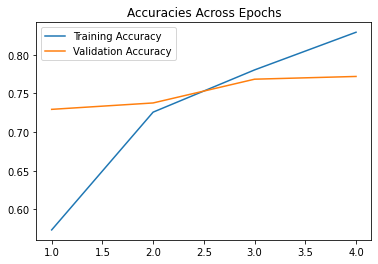

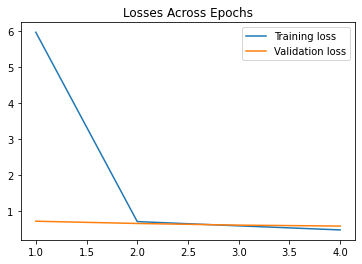

In [72]:
plt.plot(epoch_range, accuracy, label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracies Across Epochs')
plt.legend()
plt.figure()
## saved as epochs_accuracies.png

plt.plot(epoch_range, loss,  label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Losses Across Epochs')
plt.legend()
plt.show()        
## saved as epochs_losses.png

In [73]:
y_pred = model.predict(val_ds)
print(class_names[np.argmax(y_pred[1])])

27/27 [==============================] - 1s 19ms/step
Lung_Opacity


In [74]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [75]:
#FOR USE LATER

#for file in glob.glob(path_covid):
#    print(file)
#    img = cv2.imread(file,0)
#    image_list.append(img)

In [76]:
#FOR USE LATER

#image_list

In [77]:
#FOR USE LATER

#copd_list = []
#path_copd = '/tmp/COVID-19_Radiography_Dataset/Lung_Opacity/*.*'

#for file in glob.glob(path_covid):
#    print(file)
#    img = cv2.imread(file,0)
#    image_list.append(img)

In [78]:
#FOR USE LATER

#normal_list = []
#path_normal = '/tmp/COVID-19_Radiography_Dataset/Normal/*.*'

#for file in glob.glob(path_covid):
#    print(file)
#    img = cv2.imread(file,0)
#    image_list.append(img)

In [79]:
#FOR USE LATER

#pneum_list = []
#path_pneum = '/tmp/COVID-19_Radiography_Dataset/Viral_Pneumonia/*.*'

#for file in glob.glob(path_covid):
#    print(file)
#    img = cv2.imread(file,0)
#    image_list.append(img)

In [80]:
#FOR USE LATER

#covid_list = np.array(image_list)
#copd_list = np.array(copd_list)
#normal_list = np.array(normal_list)
#pneum_list = np.array(pneum_list)